# Beat US Stock market (2019)

## Problem definition

We're trying to classify the performance of stocks from the technology sector of the US stock market based on 100+ financial indicators from said stock. The model should receive those indicators from one year and **predict the stock's performance as profitable or non-profitable in the next year**.

## Success metric

Since the data we have is not very well balanced (there are a lot more Positives than Negatives) and False Positives (stocks that are predicted as being profitable but actually end up being non-profitable) are very costly, there's no doubt that **Precision** is the metric we want to evaluate success of our model.

## Importing libraries

In [127]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Reading input data and merging tables

Our dataset is composed by two different files: one of them has information relative to the 10-k fillings of the companies in 2018 and the other one has information about the price variation of the companies in 2019. 

We verified that the two dataframes didn't have the same length, so we decided to merge both of them into one single dataframe and gave a name to do first column ("Comp. Name").

In [128]:
# reading csv files
data_2018 = pd.read_csv("data/Example_DATASET.csv", na_values=['NA'])
data_2019 = pd.read_csv("data/Example_2019_price_var.csv", na_values=['NA'])

# named undefined column with "Company Name"
data_2018.columns.values[0] = "Comp. Name"
data_2019.columns.values[0] = "Comp. Name"

# merging data
all_data = pd.merge(data_2018, data_2019, on='Comp. Name', how='inner')
all_data.describe()

Revenue  Revenue Growth  Cost of Revenue  Gross Profit  \
count  6.380000e+02      638.000000     6.380000e+02  6.380000e+02   
mean   4.313656e+09        0.200593     2.418867e+09  1.893674e+09   
std    1.832010e+10        1.236156     1.060182e+10  8.412074e+09   
min    0.000000e+00       -0.959300     0.000000e+00 -2.970810e+08   
25%    1.027300e+08        0.008600     4.501450e+07  3.723250e+07   
50%    4.539775e+08        0.100800     1.950135e+08  2.097740e+08   
75%    1.896714e+09        0.231325     9.058808e+08  8.405540e+08   
max    2.655950e+11       29.980400     1.637560e+11  1.018390e+11   

       SG&A Expense  Operating Expenses  Operating Income  \
count  6.380000e+02        6.380000e+02      6.380000e+02   
mean   6.838895e+08        1.209286e+09      6.849852e+08   
std    2.367724e+09        5.087444e+09      4.005216e+09   
min    7.926000e+05       -6.190000e+05     -1.268450e+09   
25%    2.861450e+07        4.583850e+07     -9.972250e+06   
50%    1.291985e+08        1.934000e+08      8.819500e+06   
75%    4.252228e+08        6.439558e+08      1.660810e+08   
max    2.445900e+10        8.131000e+10      7.089800e+10   

       Earnings before Tax    Net Income  Net Income Com  ...  \
count         6.380000e+02  6.380000e+02    6.380000e+02  ...   
mean          6.876940e+08  5.387035e+08    5.365020e+08  ...   
std           4.214649e+09  3.416454e+09    3.416642e+09  ...   
min          -1.326000e+09 -4.964000e+09   -4.964000e+09  ...   
25%          -1.322625e+07 -1.706438e+07   -1.767875e+07  ...   
50%           6.248500e+06  4.420444e+06    4.163274e+06  ...   
75%           1.378770e+08  1.100322e+08    1.090343e+08  ...   
max           7.290300e+10  5.953100e+10    5.953100e+10  ...   

       Weighted Average Shares Growth  Weighted Average Shares Diluted Growth  \
count                      638.000000                              638.000000   
mean                         0.327554                                0.354594   
std                          4.700736                                4.719772   
min                         -0.158700                               -0.229800   
25%                         -0.000375                               -0.002425   
50%                          0.014350                                0.016250   
75%                          0.060050                                0.078225   
max                        117.904200                              117.904200   

       Operating Cash Flow growth  Free Cash Flow growth  Receivables growth  \
count                  638.000000             638.000000          638.000000   
mean                     0.024223               0.342144            0.282030   
std                     10.419881               6.941349            1.567491   
min                   -197.027800             -31.936200           -1.000000   
25%                     -0.217250              -0.316125           -0.037050   
50%                      0.118200               0.126250            0.099400   
75%                      0.497250               0.589150            0.282983   
max                     73.783500             148.819100           26.980800   

       Asset Growth  Book Value per Share Growth  SG&A Expenses Growth  \
count    638.000000                   638.000000            638.000000   
mean       0.160931                     0.134593              0.112316   
std        0.453783                     1.487802              0.231320   
min       -0.864500                   -17.090900             -0.641900   
25%       -0.032350                    -0.106900             -0.013300   
50%        0.054200                     0.035150              0.079900   
75%        0.211925                     0.174850              0.188800   
max        3.653900                    22.552600              1.944900   

            class  2019 PRICE VAR [%]  
count  638.000000          638.000000  
mean     0.706897           29.000660  
std    

## Checking Data

First, we started by checking if there was any null value in the data. Luckily, there was no need to deal with missing values, since there were none.

In [129]:
all_data.isnull().values.any()

False

Taking a look at how balanced the data is, we verify that there are more observations in class 1 than in class 0 (most of the companies registered a positive price variation in 2019), which lead us to a classification predictive modeling problem. 

<AxesSubplot:xlabel='class', ylabel='Count'>

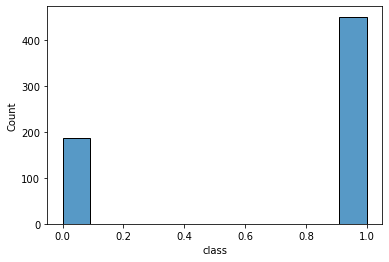

In [130]:
sb.histplot(data=all_data, x="class")

## Removing correlated features

The dataframe has 109 columns. In order to avoid duplicate features that only vary in the attribute name due to a data insertion error or cases that there is an association between the values of two columns, we decided to create a correlation matrix to eliminate the two cases mentioned above, so that we can decrease the number of attributes and have a better look at them. If the correlation between 2 columns is higher than 95%, one of them can be dropped.

In [131]:
# Create correlation matrix
corr_matrix = all_data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
all_data.drop(to_drop, axis=1, inplace=True)

## Visualizing correlation matrix

In [44]:
# correlation matrix visualization
heatMap=sb.heatmap(corr_matrix, annot=True,  cmap="YlGnBu", annot_kws={'size':12})
heatmap=plt.gcf()
heatmap.set_size_inches(120,120)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([  0.5,   5.5,  10.5,  15.5,  20.5,  25.5,  30.5,  35.5,  40.5,
         45.5,  50.5,  55.5,  60.5,  65.5,  70.5,  75.5,  80.5,  85.5,
         90.5,  95.5, 100.5, 105.5]),
 [Text(0, 0.5, 'Revenue'),
  Text(0, 5.5, 'Operating Expenses'),
  Text(0, 10.5, 'EPS'),
  Text(0, 15.5, 'EBITDA Margin'),
  Text(0, 20.5, 'EBIT'),
  Text(0, 25.5, 'Cash and short-term investments'),
  Text(0, 30.5, 'Total assets'),
  Text(0, 35.5, 'Total shareholders equity'),
  Text(0, 40.5, 'Operating Cash Flow'),
  Text(0, 45.5, 'Free Cash Flow'),
  Text(0, 50.5, 'pretaxProfitMargin'),
  Text(0, 55.5, 'fixedAssetTurnover'),
  Text(0, 60.5, 'daysOfInventoryOutstanding'),
  Text(0, 65.5, 'operatingCashFlowSalesRatio'),
  Text(0, 70.5, 'Cash per Share'),
  Text(0, 75.5, 'Earnings Yield'),
  Text(0, 80.5, 'Capex to Depreciation'),
  Text(0, 85.5, 'Invested Capital'),
  Text(0, 90.5, 'Receivables Turnover'),
  Text(0, 95.5, 'Operating Income Growth'),
  Text(0, 100.5, 'Weighted Average Shares Diluted Growth'),

## Splitting data

After analyzing and cleaning the data, we entered the stage of training the models we selected. We separated the data into a set of inputs (only necessary attributes). Then, we split the data into training and testing sets. 75% of the data will be for training and 25% for testing. Since we have an unbalanced dataframe, we will stratify the data to make sure that the percentages of each class are similar in each split.

In [132]:
from sklearn.model_selection import train_test_split

# drop unnecessary columns
all_inputs = all_data.drop(['Comp. Name', '2019 PRICE VAR [%]'], axis='columns')

# Train and Test slippiting of data, w/ a test size of 25% 
train_split, test_split = train_test_split(all_inputs, test_size=0.25, random_state=1, stratify=all_inputs['class']) 
x_train = train_split.iloc[:, :-1].values
y_train = train_split.iloc[:, -1].values
x_test = test_split.iloc[:, :-1].values
y_test = test_split.iloc[:, -1].values

## Standardizing data

Before starting to apply machine learning algorithms, there is one thing left that we need to do - data standardization. To this end, we decided to use StandardScaler from scikit-learn. If we didn't take this step, some estimators might behave badly if the individual features do not more or less look like standard normally distributed data. This way, it is important to use the same coefficients for both training and test data. The standardize variable will be applied to all classifiers used.

In [133]:
from sklearn import preprocessing

# Applying Standard scalling to get optimized results, and also because most models need to have scaled data
standardize = preprocessing.StandardScaler()
standardize.fit(x_train)
x_train = standardize.fit_transform(x_train)
x_test = standardize.fit_transform(x_test)

## Algorithms

In [134]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, plot_confusion_matrix

To avoid overfitting, we will be using cross validation for testing. We chose to use a 10-fold cross-validation as it is the most popular number of splits.

In [135]:
cross_validation = StratifiedKFold(n_splits=10)

### Decision Tree

Since we are aiming towards the best possible score, we will be using GridSearch for parameter tuning. The estimator we are using is DecisionTreeClassifier, which accepts different parameters that can be changed in order to improve the results obtained.

In [149]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree

# decision tree
decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3, 4, 5],
                  'max_features': ["auto", "sqrt", "log2"],
                  "criterion" : ["gini", "entropy"],
                  "splitter" : ["best", "random"]}


dt_grid_search = GridSearchCV(decision_tree_classifier,
                            param_grid=parameter_grid,
                            cv=cross_validation,
                            n_jobs=-1,
                            scoring="precision_weighted")

dt_grid_search.fit(x_train, y_train)
dt_classifier = dt_grid_search.best_estimator_

print('Best score and parameters, found on development set:')
print()
print('%0.3f for %r' % (dt_grid_search.best_score_, dt_grid_search.best_params_))
print()


Best score and parameters, found on development set:

0.729 for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'splitter': 'best'}



TRAINING
Accuracy score: 0.7573221757322176

TESTING
Accuracy score: 0.7

Classification Report: 
              precision    recall  f1-score   support

           0       0.49      0.47      0.48        47
           1       0.78      0.80      0.79       113

    accuracy                           0.70       160
   macro avg       0.64      0.63      0.63       160
weighted avg       0.70      0.70      0.70       160


Confusion Matrix: 


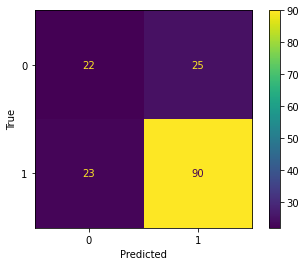

In [150]:
plot_confusion_matrix(dt_grid_search, x_test, y_test)
plt.xlabel("Predicted")
plt.ylabel("True")

print(53 * '=')
print("TRAINING")
predict_dt_train = dt_classifier.predict(x_train)
print('Accuracy score: {}'.format(accuracy_score(y_train, predict_dt_train)))
print()
print(53 * '=')
print("TESTING")
predict_dt_test = dt_classifier.predict(x_test)
print('Accuracy score: {}'.format(accuracy_score(y_test, predict_dt_test)))
print('\nClassification Report: ')
print(classification_report(y_test, predict_dt_test, labels=np.unique(predict_dt_test)))
print('\nConfusion Matrix: ')

Both training and testing scores are similar, so this is a good indicator that our model is not overfitting the training data.

The classification score and confusion score show a very significant number of false positives (25), which translates into a relatively low (47%) recall on 0. However, the recall on 1 is 80%, which means that the number of false negatives is low.

### K-Nearest Neighbors

Using the KNeighborsClassifier from sklearn and GridSearchCV to tune the folowing parameters: n_neighbors, algorithms, weights and p.

In [165]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier()


tuned_parameters = {'n_neighbors': list(range(1,30)),
                     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                     'weights': ['uniform','distance'],
                     'p':[1,2]}

knn_grid_search = GridSearchCV(knn_classifier, 
                     tuned_parameters,
                     scoring='precision_weighted',
                     n_jobs=-1,
                     cv=cross_validation)

knn_grid_search.fit(x_train, y_train)
knn_best_estimator = knn_grid_search.best_estimator_

print('Best score and parameters, found on development set:')
print()
print('%0.3f for %r' % (knn_grid_search.best_score_, knn_grid_search.best_params_))
print()

Best score and parameters, found on development set:

0.718 for {'algorithm': 'auto', 'n_neighbors': 18, 'p': 1, 'weights': 'uniform'}



As expected, this estimator gave us a worse score comparing with the last one. It is a lazy algorithm that does not need any training data points for model generation. 

TRAINING
Accuracy score: 0.7635983263598326

TESTING
Accuracy score: 0.7125

Classification Report: 
              precision    recall  f1-score   support

           0       0.53      0.17      0.26        47
           1       0.73      0.94      0.82       113

    accuracy                           0.71       160
   macro avg       0.63      0.55      0.54       160
weighted avg       0.67      0.71      0.66       160


Confusion Matrix: 


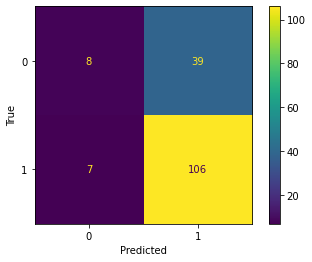

In [152]:
plot_confusion_matrix(knn_grid_search, x_test, y_test)
plt.xlabel("Predicted")
plt.ylabel("True")

print(53 * '=')
print("TRAINING")
predict_knn_train = knn_best_estimator.predict(x_train)
print('Accuracy score: {}'.format(accuracy_score(y_train, predict_knn_train)))
print()
print(53 * '=')
print("TESTING")
predict_knn_test = knn_best_estimator.predict(x_test)
print('Accuracy score: {}'.format(accuracy_score(y_test, predict_knn_test)))
print('\nClassification Report: ')
print(classification_report(y_test, predict_knn_test, labels=np.unique(predict_knn_test)))
print('\nConfusion Matrix: ')

The difference between training and testing results is higher comparing with the Decision Tree algorithm. This way, this model may be underfitting the training data and maybe this problem could have been solved by passing a lower ceiling in the n_neighbours parameter. Unfortunately, we noticed that the model started to overfit the training data after doing what we previously said.

The classification score and confusion score show a very significant number of false positives (39), which translates into a low recall on 0 (17%). However, the recall on 1 is 94%, which means that the number of false negatives is low.

### Support Vector Machines

Now, let's use the SVM algorithm. For this model, GridSearchCV will tune 4 parameters (C, kernel, gamma and shrinking).

In [153]:
from sklearn.svm import SVC

clf = SVC()

param_grid = {'C': [0.01, 0.1, 1, 10],
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
              'gamma': ['scale', 'auto'],
              'shrinking': [True, False]}

svm_grid_search = GridSearchCV(estimator=clf,
                               param_grid=param_grid,
                               scoring="precision_weighted",
                               n_jobs=-1,
                               cv=cross_validation)

svm_grid_search.fit(x_train, y_train)
svm_classifier = svm_grid_search.best_estimator_

print('Best score and parameters, found on development set:')
print()
print('%0.3f for %r' % (svm_grid_search.best_score_, svm_grid_search.best_params_))
print()

Best score and parameters, found on development set:

0.695 for {'C': 10, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True}



Our SVM model gave us the worst result, which was unexpected. It probably had a hard time because the data was too complex for any kernel to find a good decision boundary.

TRAINING
Accuracy score: 0.7740585774058577

TESTING
Accuracy score: 0.6875

Classification Report: 
              precision    recall  f1-score   support

           0       0.41      0.15      0.22        47
           1       0.72      0.91      0.80       113

    accuracy                           0.69       160
   macro avg       0.57      0.53      0.51       160
weighted avg       0.63      0.69      0.63       160


Confusion Matrix: 


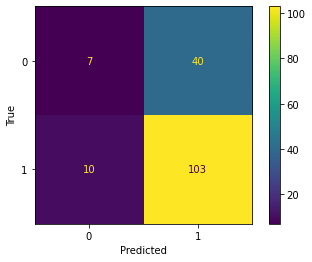

In [154]:
plot_confusion_matrix(svm_grid_search, x_test, y_test)
plt.xlabel("Predicted")
plt.ylabel("True")

print(53 * '=')
print("TRAINING")
predict_svm_train = svm_classifier.predict(x_train)
print('Accuracy score: {}'.format(accuracy_score(y_train, predict_svm_train)))
print()
print(53 * '=')
print("TESTING")
predict_svm_test = svm_classifier.predict(x_test)
print('Accuracy score: {}'.format(accuracy_score(y_test, predict_svm_test)))
print('\nClassification Report: ')
print(classification_report(y_test, predict_svm_test, labels=np.unique(predict_svm_test)))
print('\nConfusion Matrix: ')

The difference between training and testing results is even higher than KNN, so this may be suggesting that the model is overfitting the training data.

The classification score and confusion score show a very significant number of false positives (40), which translates into a low recall on 0 (15%). However, the recall on 1 is 91%, which means that the number of false negatives is low.

### Artificial Neural Network

Exploring Neural Network, we will now use the MLPClassifier. For this model, GridSearchCV will tune 6 parameters (activation, alpha, hidden_layer_sizes, learning rate, max_iter and solver).

In [155]:
from sklearn.neural_network import MLPClassifier
# Neural Newtwok Model
# An advantage of the ANN algorithm is that it can process a large amount of data.
mlpc = MLPClassifier(random_state=3, early_stopping=False)


tuned_parameters = {'hidden_layer_sizes': [(30, 15, 7), (30, 15), (30,) ],
                    'activation': ['identity', 'logistic','tanh', 'relu'],
                    'solver': ['lbfgs', 'sgd', 'adam'],
                    'learning_rate': ['constant','adaptive', 'invscaling'],
                    'alpha': [0.0001, 0.05],
                    'max_iter': [500]}

nnt_grid_search = GridSearchCV(mlpc, 
                    tuned_parameters,
                    scoring='precision_weighted',
                    n_jobs=-1,
                    cv=cross_validation)


nnt_grid_search.fit(x_train, y_train)
mlp_classifier = nnt_grid_search.best_estimator_

print('Best score and parameters, found on development set:')
print()
print('%0.3f for %r' % (nnt_grid_search.best_score_, nnt_grid_search.best_params_))
print()

Best score and parameters, found on development set:

0.745 for {'activation': 'identity', 'alpha': 0.05, 'hidden_layer_sizes': (30, 15, 7), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}



TRAINING
Accuracy score: 0.7782426778242678

TESTING
Accuracy score: 0.7125

Classification Report: 
              precision    recall  f1-score   support

           0       0.53      0.17      0.26        47
           1       0.73      0.94      0.82       113

    accuracy                           0.71       160
   macro avg       0.63      0.55      0.54       160
weighted avg       0.67      0.71      0.66       160


Confusion Matrix: 


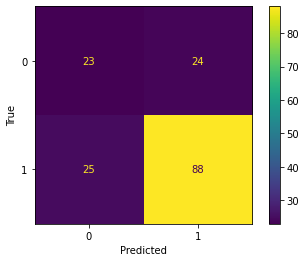

In [158]:
plot_confusion_matrix(nnt_grid_search, x_test, y_test)
plt.xlabel("Predicted")
plt.ylabel("True")

print(53 * '=')
print("TRAINING")
predict_mlpc_train = mlp_classifier.predict(x_train)
print('Accuracy score: {}'.format(accuracy_score(y_train, predict_mlpc_train)))
print()
print(53 * '=')
print("TESTING")
predict_mlpc_test = knn_best_estimator.predict(x_test)
print('Accuracy score: {}'.format(accuracy_score(y_test, predict_mlpc_test)))
print('\nClassification Report: ')
print(classification_report(y_test, predict_mlpc_test, labels=np.unique(predict_mlpc_test)))
print('\nConfusion Matrix: ')

As expected, Neural Networks got us our best result, in what concerns "precision_weighted" scoring.
The classification score and confusion score show that this model has the lowest false positives so far (24). However, it also gave us the highest false negatives (25).

## Comparing Results

Let's check precision weighted scores.

[Text(0, 0, 'Decision Trees'),
 Text(1, 0, 'Neural Network'),
 Text(2, 0, 'Support Vector Machines'),
 Text(3, 0, 'K-Nearest Neighbours')]

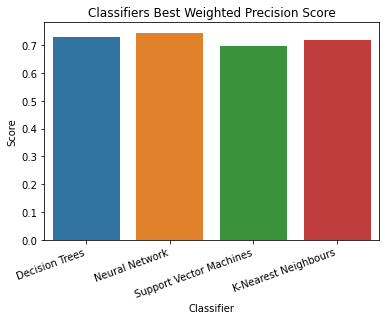

In [168]:
score_df = pd.DataFrame()
best_scores = {}
best_scores['Decision Trees'] = dt_grid_search.best_score_
best_scores['Neural Network'] = nnt_grid_search.best_score_
best_scores['Support Vector Machines'] = svm_grid_search.best_score_
best_scores['K-Nearest Neighbours'] = knn_grid_search.best_score_
for name, score in best_scores.items():
    score_df = score_df.append(pd.DataFrame({'Score': [score], 'Classifier': [name]}))
ax = sb.barplot(x='Classifier', y='Score', data=score_df)
ax.set_title('Classifiers Best Weighted Precision Score')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')

Let's take a look at the accuracy score of the same models to evaluate their performance with the testing split.

[Text(0, 0, 'Decision Trees'),
 Text(1, 0, 'Neural Networks'),
 Text(2, 0, 'Support Vector Machine'),
 Text(3, 0, 'K Nearest Neighbours')]

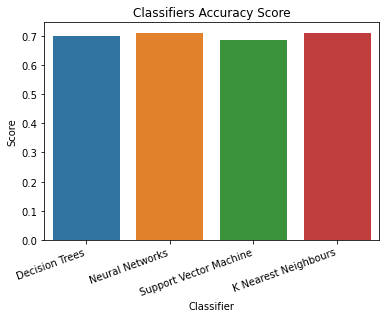

In [169]:
score_df = pd.DataFrame()
accuracy_scores = {}
accuracy_scores['Decision Trees'] = 0.7
accuracy_scores['Neural Networks'] = 0.7125
accuracy_scores['Support Vector Machine'] = 0.6875
accuracy_scores['K Nearest Neighbours'] = 0.7125
for name, score in accuracy_scores.items():
    score_df = score_df.append(pd.DataFrame({'Score': [score], 'Classifier': [name]}))
ax = sb.barplot(x='Classifier', y='Score', data=score_df)
ax.set_title('Classifiers Accuracy Score')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')

It is also important to see the range of scores in each split.

[Text(0, 0, 'Decision Trees'),
 Text(1, 0, 'Neural Networks'),
 Text(2, 0, 'Support Vector Machine'),
 Text(3, 0, 'K-Nearest Neighbours')]

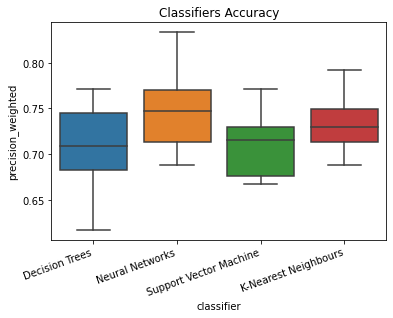

In [170]:
from sklearn.model_selection import cross_val_score
classifiers = {}
classifiers['Decision Trees'] = dt_grid_search.best_estimator_
classifiers['Neural Networks'] = nnt_grid_search.best_estimator_
classifiers['Support Vector Machine'] = svm_grid_search.best_estimator_
classifiers['K-Nearest Neighbours'] = knn_grid_search.best_estimator_
clf_df = pd.DataFrame()
for name, clf in classifiers.items():
    clf_df = clf_df.append(pd.DataFrame({'precision_weighted': cross_val_score(clf, x_train, y_train, cv=StratifiedKFold(n_splits=10)),
                       'classifier': [name] * 10}))

ax = sb.boxplot(x='classifier', y='precision_weighted', data=clf_df)
ax.set_title('Classifiers Accuracy')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')

Checking the fit time.

[Text(0, 0, 'Decision Trees'),
 Text(1, 0, 'Neural Network'),
 Text(2, 0, 'Support Vector Machines'),
 Text(3, 0, 'K-Nearest Neighbours')]

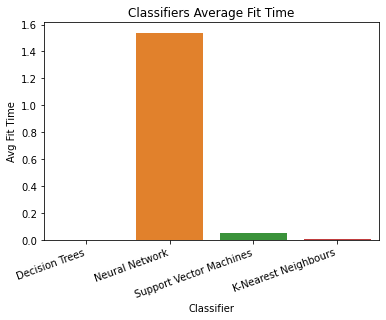

In [172]:
fittime_df = pd.DataFrame()
fit_times = {}
fit_times['Decision Trees'] = np.mean(dt_grid_search.cv_results_['mean_fit_time'])
fit_times['Neural Network'] = np.mean(nnt_grid_search.cv_results_['mean_fit_time'])
fit_times['Support Vector Machines'] = np.mean(svm_grid_search.cv_results_['mean_fit_time'])
fit_times['K-Nearest Neighbours'] = np.mean(knn_grid_search.cv_results_['mean_fit_time'])
for name, fittime in fit_times.items():
    fittime_df = fittime_df.append(pd.DataFrame({'Avg Fit Time': [fittime], 'Classifier': [name]}))
    
ax = sb.barplot(x='Classifier', y='Avg Fit Time', data=fittime_df)
ax.set_title('Classifiers Average Fit Time')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')

# Conclusions

Since the metric we wanted to maximize in our problem was precision, according to our results, we concluded that the most appropriate algorithm for this was Neural Networks.<br>
This work was based on the experimentation of the possible parameters to be used to fit the models.<br>
We learned about the impact the data can have on the results and the importance of its treatment. The improvement of the results was substantial after we cleaned the data more carefully.